<a href="https://colab.research.google.com/github/tamnhu2913/Applied-Social-Network-Analysis/blob/main/assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

In [42]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
G1 = pickle.load(open('assets/A4_P1_G1', 'rb'))
G2 = pickle.load(open('assets/A4_P1_G2', 'rb'))
G3 = pickle.load(open('assets/A4_P1_G3', 'rb'))
G4 = pickle.load(open('assets/A4_P1_G4', 'rb'))
G5 = pickle.load(open('assets/A4_P1_G5', 'rb'))
P1_Graphs = [G1, G2, G3, G4, G5]

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs using any methodology and determine which of the three algorithms generated each graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

In [3]:
def graph_identification():
  def var_degree(G):
    import operator
    degrees = G.degree()
    df = pd.DataFrame(degrees, columns =['Node', 'Degree'])
    return df['Degree'].std()

  result = []
  for G in P1_Graphs:
    if var_degree(G) > 1 and nx.average_clustering(G) < 0.1:
      result.append('PA')
    elif nx.average_clustering(G) > 0.4:
      result.append('SW_L')
    else:
      result.append('SW_H')
  return result

graph_identification()

['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

In [4]:
ans_one = graph_identification()
assert type(ans_one) == list, "You must return a list"


---

## Part 2 - Company Emails

For the second part of this assignment you will be working with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagmentSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagmentSalary` indicates whether that person is receiving a managment position salary.

In [5]:
G = pickle.load(open('assets/email_prediction_NEW.txt', 'rb'))

print(f"Graph with {len(nx.nodes(G))} nodes and {len(nx.edges(G))} edges")

Graph with 1005 nodes and 16706 edges


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a managment position salary.

To accomplish this, you will need to create a matrix of node features of your choice using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a managment salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a managment position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a Pandas series of length 252 with the data being the probability of receiving managment salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [6]:
list(G.nodes(data=True))[:5] # print the first 5 nodes

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (581, {'Department': 3, 'ManagementSalary': 0.0}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (65, {'Department': 4, 'ManagementSalary': nan})]

In [7]:
# df = pd.DataFrame(G.nodes(data=True), columns = ['Node', 'Type'])
# df['ManagementSalary'] = df['Type'].apply(lambda x: x['ManagementSalary'])
# df['Department'] = df['Type'].apply(lambda x: x['Department'])
# df.drop('Type', axis = 1, inplace = True)

# df['Degree'] = [d for _, d in G.degree()]
# df['DegreeCentrality'] = nx.degree_centrality(G)
# df['Closeness'] = nx.closeness_centrality(G)
# df['Betweeness'] = nx.betweenness_centrality(G, normalized = True)
# df['Clusterting'] = nx.clustering(G)

# train = df[df['ManagementSalary'].notnull()]
# test = df[df['ManagementSalary'].isnull()]

# df.head()

,Node,ManagementSalary,Department,Degree,DegreeCentrality,Closeness,Betweeness,Clusterting
0,0,0.0,1,44,0.043825,0.421991,0.001124,0.276423
1,1,NaN,1,52,0.051793,0.422360,0.001195,0.265306
2,581,0.0,3,32,0.094622,0.461490,0.006570,0.297803
3,6,1.0,25,115,0.070717,0.441663,0.001654,0.384910
4,65,NaN,4,91,0.095618,0.462152,0.005547,0.318691


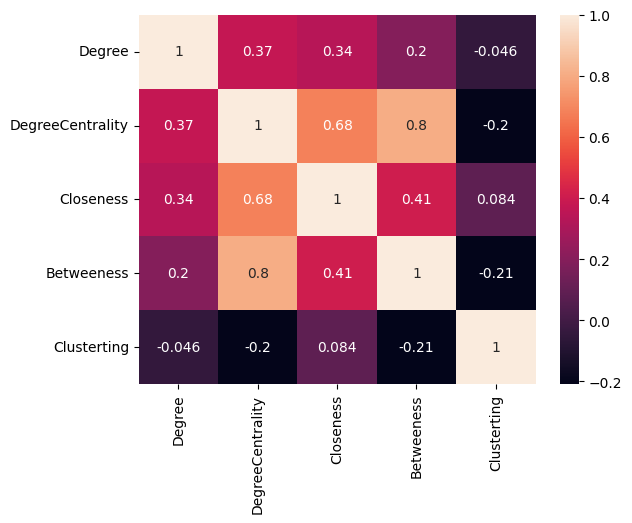

In [8]:
# feature = ['Degree', 'DegreeCentrality', 'Closeness', 'Betweeness', 'Clusterting']
# corr = train[feature].corr()
# sns.heatmap(corr, annot = True)
# plt.show()

Since the correlation between the three types of centrality is quite high, I will choose one of them as a feature.

In [13]:
def true_data():
  true_values = pd.read_csv('assets/true_node_salaries', header=None, sep=',')
  true_values.columns = ['Node', 'ManagementSalary']
  true_values.index = true_values['Node']
  true_values = true_values['ManagementSalary']
  true_values = true_values.sort_index()
  return true_values

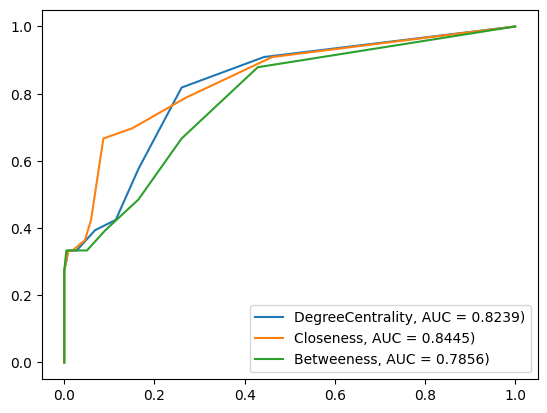

In [15]:
# f1 = ['Department','Degree', 'Clusterting']
# f2 = ['DegreeCentrality', 'Closeness', 'Betweeness']
# model = RandomForestClassifier(n_estimators = 10, random_state = 0)
# for f in f2:
#   X = train[f1+[f]]
#   y = train['ManagementSalary']
#   X_test = test[f1+[f]]

#   X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state = 0)

#   model.fit(X_train, y_train)
#   pred = pd.DataFrame(model.predict_proba(X_test)[:,1], index = test['Node']).sort_index()
#   fpr_svm, tpr_svm, _ = roc_curve(true_data(), pred)
#   auc_svm = auc(fpr_svm, tpr_svm)
#   plt.plot(fpr_svm, tpr_svm, label = '{}, AUC = {:.4f})'.format(f, auc_svm))

# plt.legend(fontsize=10, loc = 'lower right')
# plt.show()

We observed that the AUC of Closeness Centrality is the highest, so Closeness Centrality is the feature I will use.

In [16]:
# X = train[['Department','Degree', 'Clusterting','Closeness']]
# y = train['ManagementSalary']
# X_test = test[['Department','Degree', 'Clusterting','Closeness']]
# X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state = 0)
# model = RandomForestClassifier(random_state=0)
# param = {'n_estimators': [5,10,20,50,100],
#             'max_depth':[None,1,2,3]}

# grid = GridSearchCV(model, param_grid = param)
# grid.fit(X_train, y_train)
# print('Best parameters (max accuracy): ', grid.best_params_)
# print('Best score (accuracy): ', grid.best_score_)

Best parameters (max accuracy):  {'max_depth': 2, 'n_estimators': 20}
Best score (accuracy):  0.8820385674931129


In [43]:
def salary_predictions():
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score

    df = pd.DataFrame(index = G.nodes)
    df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
    df['Department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
    df['Degree'] = [d for _, d in G.degree()]
    df['Closeness'] = nx.closeness_centrality(G)
    df['Clusterting'] = nx.clustering(G)

    scaler = StandardScaler()
    df['Degree'] = scaler.fit_transform(df['Degree'].values.reshape(-1, 1))

    train = df[df['ManagementSalary'].notnull()]
    test = df[df['ManagementSalary'].isnull()]

    X_train, X_cv, y_train, y_cv = train_test_split(train.drop(columns = ['ManagementSalary']), train['ManagementSalary'],
                                                    test_size=0.2, random_state=0)

    cls = RandomForestClassifier(n_estimators = 20, max_depth = 2, random_state = 0).fit(X_train,  y_train)

    print('AUC score of train set: ', roc_auc_score(y_train, cls.predict_proba(X_train)[:,1]))
    print('AUC score of cv set: ', roc_auc_score(y_cv, cls.predict_proba(X_cv)[:,1]))

    pred = cls.predict_proba(test.drop(columns = ['ManagementSalary']))[:,1]
    return pd.Series(pred, index = test.index).sort_index()

salary_predictions()

AUC score of train set:  0.89452610342556
AUC score of cv set:  0.8666779891304347


,0
1,0.167738
2,0.501140
5,0.840170
8,0.152097
14,0.328452
...,...
992,0.021791
994,0.021791
996,0.021791
1000,0.058936


In [44]:
ans_salary_preds = salary_predictions()
assert type(ans_salary_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_salary_preds) == 252, "The series must be of length 252"


AUC score of train set:  0.89452610342556
AUC score of cv set:  0.8666779891304347


In [45]:
print('AUC score: ', roc_auc_score(true_data(), ans_salary_preds))

AUC score:  0.9097827590978276


### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [26]:
future_connections = pd.read_csv('assets/Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to:      
1. Create a matrix of features of your choice for the edges found in `future_connections` using Networkx     
2. Train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data     
3. Predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [27]:
# future_connections['Common Neighbors'] = future_connections.index.map(lambda x: len(list(nx.common_neighbors(G, x[0],x[1]))))
# future_connections['Jaccard Coefficient'] = future_connections.index.map(lambda x: list(nx.jaccard_coefficient(G, [(x[0], x[1])]))[0][2])
# future_connections['Resource Allocation'] = future_connections.index.map(lambda x: list(nx.resource_allocation_index(G, [(x[0], x[1])]))[0][2])
# future_connections['Adamic Adar'] = future_connections.index.map(lambda x: list(nx.adamic_adar_index(G, [(x[0], x[1])]))[0][2])
# future_connections['Preferential Attachment'] = future_connections.index.map(lambda x: list(nx.preferential_attachment(G, [(x[0], x[1])]))[0][2])

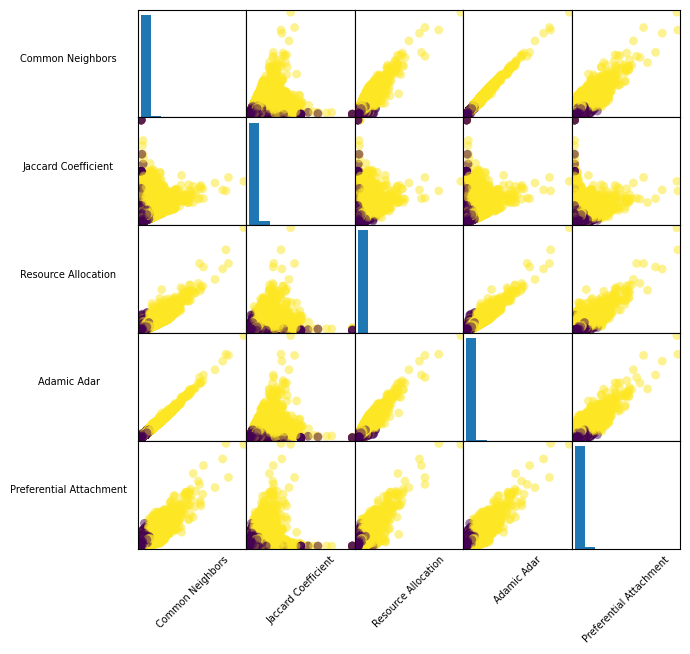

In [39]:
# train = future_connections[future_connections['Future Connection'].notnull()]
# test = future_connections[future_connections['Future Connection'].isnull()]

# feature = ['Common Neighbors','Jaccard Coefficient','Resource Allocation', 'Adamic Adar', 'Preferential Attachment']
# n = train['Future Connection']
# scatter = pd.plotting.scatter_matrix(train[feature], c = n, marker = 'o', s = 40, hist_kwds = {'bins':10}, figsize = [7,7])

# for ax in scatter.flatten():
#     ax.set_xlabel(ax.get_xlabel(), fontsize=7, rotation=45)
#     ax.set_ylabel(ax.get_ylabel(), fontsize=7, rotation=0, labelpad=50)
#     ax.set_xticks(())
#     ax.set_yticks(())

# plt.show()

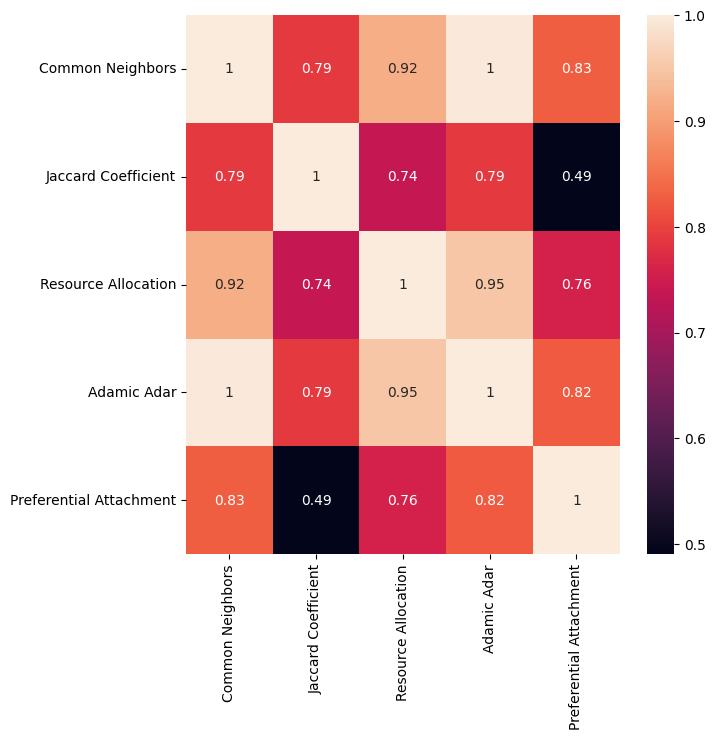

In [20]:
# corr = train[feature].corr()
# plt.figure(figsize=(7,7))
# sns.heatmap(corr,annot=True)
# plt.show()

Since, the correlation of Common Neighbors, Resource Allocation and Adamic Adar are very high. Therefore, we use Jaccard Coefficient and Preferential Attachment as features.

In [21]:
# X = train.drop(columns = ['Future Connection'])
# y = train['Future Connection']
# X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=0)
# model = RandomForestClassifier(random_state=0)
# param = {'n_estimators': [5,10,20,50,100],
#             'max_depth':[None,1,2]}

# grid = GridSearchCV(model, param_grid = param)
# grid.fit(X_train, y_train)
# print('Best parameters (max accuracy): ', grid.best_params_)
# print('Best score (accuracy): ', grid.best_score_)

Best parameters (max accuracy):  {'max_depth': None, 'n_estimators': 100}
Best score (accuracy):  0.9571906769159456


In [46]:
def new_connections_predictions():
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score

    future_connections = pd.read_csv('assets/Future_Connections.csv', index_col=0, converters={0: eval})
    future_connections['Jaccard Coefficient'] = future_connections.index.map(lambda x: list(nx.jaccard_coefficient(G, [(x[0], x[1])]))[0][2])
    future_connections['Preferential Attachment'] = future_connections.index.map(lambda x: list(nx.preferential_attachment(G, [(x[0], x[1])]))[0][2])

    train = future_connections[future_connections['Future Connection'].notnull()].copy()
    test = future_connections[future_connections['Future Connection'].isnull()].copy()

    scaler = StandardScaler().fit(train['Preferential Attachment'].values.reshape(-1, 1))
    train['Preferential Attachment'] = scaler.transform(train['Preferential Attachment'].values.reshape(-1, 1))
    test['Preferential Attachment'] = scaler.transform(test['Preferential Attachment'].values.reshape(-1, 1))

    X_train, X_cv, y_train, y_cv = train_test_split(train.drop(columns = ['Future Connection']), train['Future Connection'],
                                                        test_size=0.2, random_state=0)

    model = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 0)
    model.fit(X_train, y_train)
    print('AUC score of train set: ', roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    print('AUC score of cv set: ', roc_auc_score(y_cv, model.predict_proba(X_cv)[:,1]))
    pred = pd.Series(model.predict_proba(test.drop(columns = ['Future Connection']))[:,1], index = test.index)
    return pred

new_connections_predictions()

AUC score of train set:  0.8948351476908033
AUC score of cv set:  0.8939907226124398


,0
"(107, 348)",0.027259
"(542, 751)",0.027259
"(20, 426)",0.654690
"(50, 989)",0.027259
"(942, 986)",0.027259
...,...
"(165, 923)",0.027259
"(673, 755)",0.027259
"(939, 940)",0.027259
"(555, 905)",0.027259


In [47]:
ans_prob_preds = new_connections_predictions()
assert type(ans_prob_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_prob_preds) == 122112, "The series must be of length 122112"


AUC score of train set:  0.8948351476908033
AUC score of cv set:  0.8939907226124398


In [49]:
true = pd.read_csv('assets/Future_Connections_testing.csv', names = ['Future Connection'], index_col=0, header = None)
true

,Future Connection
"(107, 348)",0
"(542, 751)",0
"(20, 426)",0
"(50, 989)",0
"(942, 986)",0
...,...
"(165, 923)",0
"(673, 755)",0
"(939, 940)",0
"(555, 905)",0


In [50]:
print('AUC score: ', roc_auc_score(true, ans_prob_preds))

AUC score:  0.8936439027973798
